<p>As discussed in my <a href="http://khalibartan.github.io/Introduction-to-Markov-Chains">previous post</a> , we can use a Markov chain to sample from some target probability distribution $p(x)$. To do so, it is necessary to design transition operator for the Markov Chain such that the stationary distribution of chain matches the target distribution $p(x)$. The Metropolis-Hastings sampling algorithm allows us to build such Markov chains.</p> <h2 id="detailed-balance">Detailed Balance</h2> <p>To understand how Metropolis-Hastings enable us constructs such chains we need to understand reversibility in Markov Chain. In my previous post I briefly described reversibility as,</p> <blockquote> <p>if the probability of transition $P^{(t)}(X^{(t)}) \rightarrow P^{(t+1)}(X^{(t+1)})$ is same as the probability of reverse transition $P^{(t+1)}(X^{(t+1)}) \rightarrow P^{(t)}(X^{(t)})$ then chain is reversible.</p> </blockquote> <p>Mathematically we can write this as:</p> 



$$\pi(x)T(x \rightarrow x') = \pi(x')T(x' \rightarrow x)$$ 

<p>This equation is called as <strong>detailed balance</strong>.</p> <p>Now if the transition operator $T$ is regular( A Markov chain is regular if if there exists some number $k$ such that, for every $x, x' \in Val(X)$, the probability of getting from $x$ to $x'$ in exactly $k$ steps is greater than 0. ) and it satisfies the detailed balance equation relative to $\pi$, then $\pi$ is the unique stationary distribution of $T$ (For proof refer <a href="http://faculty.washington.edu/harin/markovchain_proofs.pdf">here</a>).</p> <h1 id="metropolis-hastings-algorithm">Metropolis-Hastings Algorithm</h1> <p>Let $\pi(x)$ be the desired stationary distribution which matches the target probability distribution $p(x)$. Let $x, x'$ be any to states belonging to state-space of Markov chain. Now using detailed balance equation</p> 

$$\pi(x)T(x \rightarrow x') = \pi(x')T(x' \rightarrow x)$$ 


<p>which can be re-written as:</p> 

$$\frac{T(x \rightarrow x')}{T(x' \rightarrow x)} = \frac{\pi(x')}{\pi(x)}$$ 

<p>Now, we will separate the transition in two sub-steps ( I’ll explain why in a moment ), the proposal and the acceptance-rejection. The <strong>proposal distribution</strong> $Q(x \rightarrow x')$ is the probability of proposing a state $x'$ given $x$, and the <strong>acceptance probability</strong> $A(x \rightarrow x')$ is the conditional probability to accept the proposed state $x'$. Transition probability $T$ can be written as the product of both:</p> 


$$T(x \rightarrow x') = Q(x \rightarrow x')A(x \rightarrow x')$$

<p>Using this relation we can re-write the previous equation as:</p> 

$$\frac{Q(x \rightarrow x')A(x \rightarrow x')}{Q(x' \rightarrow x)A(x' \rightarrow x)} = \frac{\pi(x')}{\pi(x)}$$

$$\frac{A(x \rightarrow x')}{A(x' \rightarrow x)} = \frac{\pi(x')Q(x' \rightarrow x)}{\pi(x)Q(x \rightarrow x')}$$

<p>Now since $A$ lies in $[0, 1]$, and we want to maximize the acceptance of new proposed state $x'$ thus we choose acceptance probability as</p> 

$$A(x \rightarrow x') = min \left(1, \frac{\pi(x')Q(x' \rightarrow x)}{\pi(x)Q(x \rightarrow x')} \right)$$ 

<p>Now acceptance probability is a probability associated with an event of accepting new proposed state, so whenever our acceptance probability is $1$ we accept the new proposed state. But what about the case when acceptance probability lies in $[0, 1)$, i.e less than $1$. In such cases we take a random sample from $Uniform[0, 1)$ and if acceptance probability is higher than this number we accept new state otherwise reject it. In some place this criterion is called as <strong>Metropolis acceptance criterion</strong>.</p> <p>In nutshell we can write Metropolis-Hastings algorithm as following procedure :</p> <ol> <li> <p>Initialisation: Pick an initial state $x$ at random</p> </li> <li> <p>Randomly pick new proposed state $x'$ according to $Q(x \rightarrow x')$</p> </li> <li> <p>Accept the state according to Metropolis acceptance criterion. If state is accepted set the current state to $x'$, otherwise set it to $x$. Yield this current state as sample</p> </li> <li> <p>Go to step 2 until required number of samples are generated.</p> </li> </ol> <p>There are few attractive properties of Metropolis-Hastings algorithm which may not be visible in first-sight.</p> <ul> <li> <p>First, the use of proposal distribution for sampling. The advantage of using proposal distribution is that it allows us to indirectly sample from the target distribution when it is too complex to directly sample from.</p> </li> <li> <p>Secondly, our target distribution doesn’t need to be normalized. We can use un-normalized target distribution and our sample will be as good as in the case of normalized target distribution. If you carefully look at the calculation of acceptance probability we are using ratio of target distribution, thus normalizing constant cancels out. The calculation of normalizing constant is itself difficult (requires numeric integration).</p> </li> </ul> <p>Now the reason to split transition probability must be clear because it allows us take advantage of proposal distribution.</p> <p>Enough of this theory, let’s now use this algorithm and try to find samples from <a href="https://en.wikipedia.org/wiki/Beta_prime_distribution">beta prime distribution</a></p> <p>The probability density function of beta prime distribution is defined as:</p> 

$$p(x) = \frac{x^{\alpha-1}(1+x)^{- \alpha- \beta}}{B(\alpha, \beta)}$$ <p>where $B$ is a Beta function. We will ignore this normalizing constant.</p> <p>Since Beta prime distribution is defined for $x>0$, we will choose our proposal distribution $Q$ as <a href="https://en.wikipedia.org/wiki/Exponential_distribution">exponential distribution</a></p> <p>$f(x) = \lambda e^{-\lambda x}$,</p> <p>where parameter $\lambda$ controls the scale of distribution.</p> <p>We will define our target distribution such as scale is our previous value of sample</p>

$$Q(x \rightarrow x') = xe^{-xx'}$$

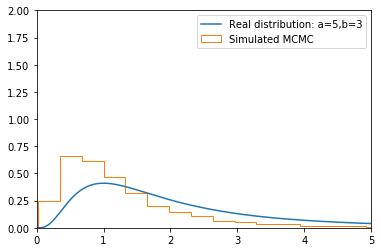

In [2]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

# Defining beta prime function, valued returned is un-normalized probability
beta_prime = lambda x, a, b: x**(a-1)*(1+x)**(-a-b)

# Defining the transition function Q
q = lambda x, scale: np.exp(-scale*x)

def mcmc_beta_prime(num_samples, a, b, warm_up):
    np.random.seed(12345)
    samples = []
    x = np.random.exponential(1)  # The inital state x
    for i in range(0, num_samples):
        samples.append(x)
        x_prime = np.random.exponential(1/x)  # The new proposed state x'
        factor = q(x, x_prime)/q(x_prime, x)

        # The acceptance probability
        A = min(1, factor * beta_prime(x_prime, a, b) / beta_prime(x, a, b))

        # Accepting or rejecting based on Metropolis acceptance criterion
        u = np.random.uniform(0, 1)
        if u < A:
            x = x_prime
        else:
            x = x
    return samples[warm_up:]  # Discards samples from initial warm-up period

# This function plots actual beta prime distribution against sampled
def plot_beta_prime_and_samples(a, b):
    plt.figure()
    x = np.linspace(0, 100, 10000)
    y = [ss.betaprime.pdf(x_i, a, b) for x_i in x]
    plt.plot(x, y, label='Real distribution: a='+str(a)+',b='+str(b))
    plt.hist(mcmc_beta_prime(100000, a,b, 1000), density=True, histtype='step',
             bins=100, label="Simulated MCMC")
    plt.xlim([0, 5])
    plt.ylim([0, 2])
    plt.legend()
    plt.show()
    plt.close()

plot_beta_prime_and_samples(5, 3)

<p><img src="http://khalibartan.github.io/img/beat_prime_simulation.png" alt="beta_prime_simulation"></p> <p>As we can see our sampled beta prime values closely resemble the beta prime distribution</p> <p>The Metropolis-Hastings algorithm is a Markov chain Monte Carlo algorithm that can be used to draw samples from both discrete and continuous probability distributions of all kinds, as long as we compute a function f that is proportional to the density of target distribution. But one disadvantage of Metropolis-Hastings algorithm is that it has poor convergence rate. Lets look at an example to understand what I meant by “poor convergence”. In this example we will draw samples from 2D <a href="https://en.wikipedia.org/wiki/Multivariate_normal_distribution">Multivariate normal distribution</a></p> <p>Multivariate normal distribution is represented as $p(x) = N(\mu, \Sigma)$, where $\mu$ is mean vector, and $\Sigma$ is covariance matrix.</p> <p>Probability density at any point $x$ is given by:</p> $p(x) = Ze^{-\frac{1}{2}(x-\mu)' \Sigma ^{-1}(x-\mu)}$ <p>where is Z is normalizing constant</p> <p>Our target distribution will have</p> <p>mean</p> 


\mu = [0, 0] <p>and covariance</p> 

\Sigma = \left[ \begin{array}{cc} 1 \qquad 0.97 \newline 0.97 \qquad 1 \end{array} \right]


<p>Our proposal distribution will be a multivariate normal distribution centred at previous state and unit covariance i.e,</p> <p>Q(x \rightarrow x') = N(x, I),</p> <p>where I is an identity matrix</p> 

<p>In plot we can see that Metropolis-Hastings algorithm takes time to converge towards target distribution (slow mixing). Like Metropolis-Hastings algorithm many MCMC algorithm suffer from this slow mixing. Slow mixing happens because of a number of factors like random-walk nature of the Markov chain, tendency of getting stuck at a particular sample and only sampling from a single region having high probability density. In my next post we will look at some of the more advance MCMC techniques namely Hybrid Monte Carlo (Hamiltonian Monte Carlo / HMC) and No-U-Turn Sampler (NUTS), which enables us to explore target distribution more efficiently.</p> <p>In examples of next post I will use my own implementation of HMC and NUTS (which I implemented under pgmpy) and thus will require a latest installation of pgmpy in working env. For installation instruction you can look at <a href="https://github.com/pgmpy/pgmpy">here</a>.</p>